In [23]:
import pandas as pd

# Load the dataset
data_path = '../Cleaned_Data/Zip_zori_uc_sfrcondomfr_sm_month.csv'
rent_data = pd.read_csv(data_path)

# Filter data for rows where the City is 'Boston'
boston_rent_data = rent_data[rent_data['City'] == 'Boston']

# Add a leading zero to the ZIP code values
boston_rent_data['RegionName'] = boston_rent_data['RegionName'].astype(str).apply(lambda x: x.zfill(5))

# Keep only the ZIP and 2024-03-31 columns
zori_data = boston_rent_data[['RegionName', '2024-03-31']].rename(columns={'RegionName': 'ZIP_CODE', '2024-03-31': 'PRICE_INDEX'})

/var/folders/yw/mznj9c1d7qs7dj34_fn1d7b40000gn/T/ipykernel_97237/1417317334.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_rent_data['RegionName'] = boston_rent_data['RegionName'].astype(str).apply(lambda x: x.zfill(5))


In [24]:
# Load the property assessment dataset
property_data_path = '../Cleaned_Data/cleaned_PROPERTY_ASSESSMENT.csv'
property_data = pd.read_csv(property_data_path)

# Select relevant columns and clean data
property_data = property_data[['ZIP_CODE', 'RES_UNITS']]
property_data.dropna(inplace=True)  # Remove rows where any of these two columns are missing
property_data['ZIP_CODE'] = property_data['ZIP_CODE'].astype(int).astype(str).str.zfill(5)  # Format ZIP_CODE with leading zeros

# Summarize residential units by ZIP code
res_units_by_zip = property_data.groupby('ZIP_CODE')['RES_UNITS'].sum().reset_index()

# Save the summarized data to a new CSV file
# res_units_by_zip.to_csv('data/residential_units_by_zip.csv', index=False)

/var/folders/yw/mznj9c1d7qs7dj34_fn1d7b40000gn/T/ipykernel_97237/2837436820.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(property_data_path)


In [25]:
# Load dataset
service_requests = pd.read_csv('../Cleaned_Data/cleaned_311_Service_Requests_2024.csv')

# Count the number of cases by ZIP code
zipcode_counts = service_requests['location_zipcode'].value_counts().reset_index()
zipcode_counts.columns = ['ZIP_CODE', 'CASE_COUNT']

# Convert ZIP_CODE to string, format as five digits
zipcode_counts['ZIP_CODE'] = zipcode_counts['ZIP_CODE'].apply(lambda x: f"{int(x):05d}")

# Output the counts
print(zipcode_counts)

# Save to new CSV file
# zipcode_counts.to_csv('data/zipcode_case_counts.csv', index=False)

   ZIP_CODE  CASE_COUNT
0     02127        2582
1     02124        2177
2     02128        1921
3     02118        1890
4     02135        1729
5     02130        1728
6     02125        1516
7     02119        1343
8     02116        1293
9     02131        1162
10    02122        1147
11    02132        1096
12    02114        1091
13    02126        1057
14    02121        1056
15    02136         988
16    02129         913
17    02134         873
18    02113         559
19    02115         519
20    02120         493
21    02215         425
22    02108         422
23    02111         269
24    02109         228
25    02210         164
26    02110          85
27    02467          26
28    02199          18
29    02201          17
30    02203           3
31    02133           2
32    02163           1
33    02445           1


In [26]:
# Merge the datasets on ZIP_CODE
freq_data = pd.merge(zipcode_counts, res_units_by_zip, on='ZIP_CODE', how='left')

# Calculate violation frequency
freq_data['VIOLATION_FREQUENCY'] = freq_data['CASE_COUNT'] / freq_data['RES_UNITS'] * 1000

# Output the merged data
print(freq_data)

# Save to new CSV file
# merged_data.to_csv('data/violation_per_1000_units_by_zip.csv', index=False)

   ZIP_CODE  CASE_COUNT  RES_UNITS  VIOLATION_FREQUENCY
0     02127        2582     7829.0           329.799464
1     02124        2177     1766.0          1232.729332
2     02128        1921     3372.0           569.691578
3     02118        1890     5381.0           351.235830
4     02135        1729     6153.0           281.001138
5     02130        1728     5359.0           322.448218
6     02125        1516     2156.0           703.153989
7     02119        1343     1203.0          1116.375727
8     02116        1293     6775.0           190.848708
9     02131        1162     2159.0           538.212135
10    02122        1147     1733.0           661.858050
11    02132        1096     1325.0           827.169811
12    02114        1091     3232.0           337.561881
13    02126        1057      337.0          3136.498516
14    02121        1056      504.0          2095.238095
15    02136         988      916.0          1078.602620
16    02129         913     3679.0           248

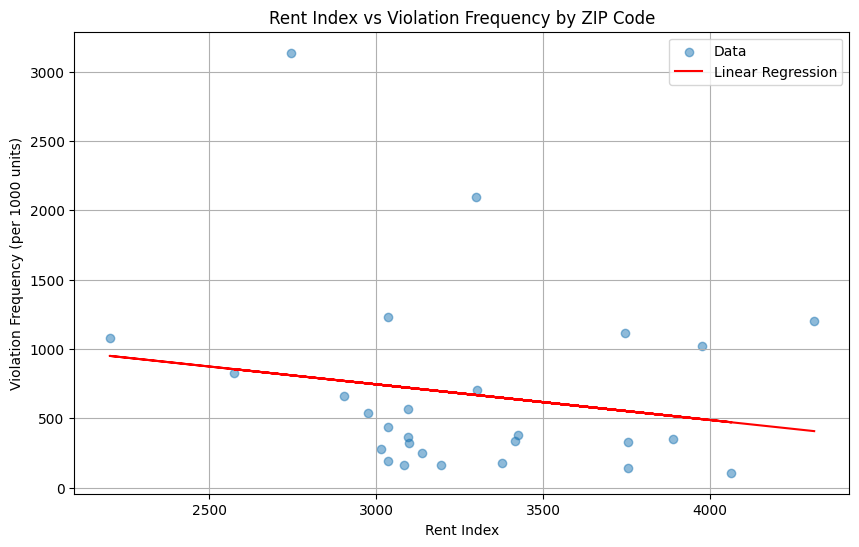

Intercept: 1516.581951826131
Coefficient: -0.25722029102166505
R-squared: 0.03266538023619969


In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Merge datasets on ZIP code
merged_data = pd.merge(zori_data, freq_data, on='ZIP_CODE', how='inner')

# Prepare data for linear regression
X = merged_data['PRICE_INDEX'].values.reshape(-1, 1)
y = merged_data['VIOLATION_FREQUENCY'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Predict y values
y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.title('Rent Index vs Violation Frequency by ZIP Code')
plt.xlabel('Rent Index')
plt.ylabel('Violation Frequency (per 1000 units)')
plt.grid(True)
plt.legend()
plt.show()

# Print the coefficients
print('Intercept:', model.intercept_)
print('Coefficient:', model.coef_[0])
print('R-squared:', r2_score(y, y_pred))


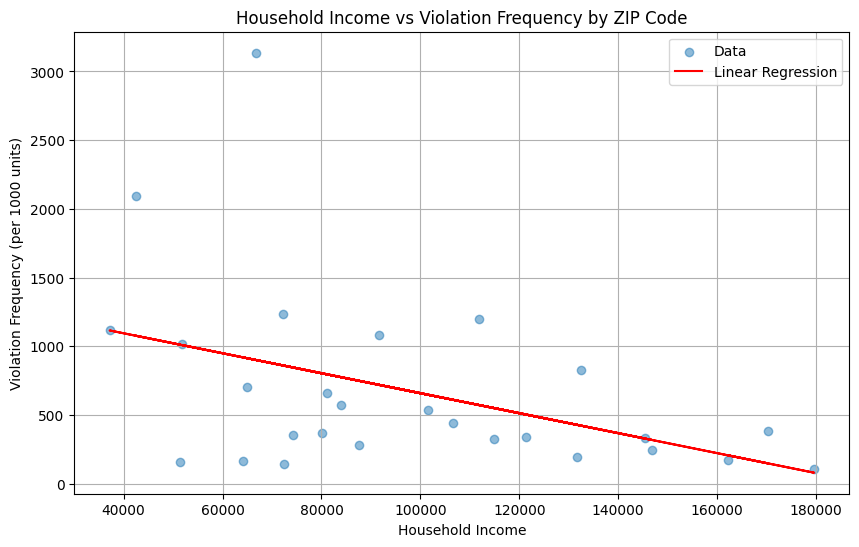

Intercept: 1385.383005699005
Coefficient: -0.0072670070354724885
R-squared: 0.18391268708242836


In [28]:
# Load datasets
zip_and_income = pd.read_csv('../Cleaned_Data/income_by_zip.csv')

zip_and_income['ZIP_CODE'] = zip_and_income['ZIP_CODE'].astype(int)
freq_data['ZIP_CODE'] = freq_data['ZIP_CODE'].astype(int)

# Merge datasets on ZIP code
merged_data = pd.merge(zip_and_income, freq_data, on='ZIP_CODE', how='inner')

# Prepare data for linear regression
X = merged_data['HOUSEHOLD_INCOME'].values.reshape(-1, 1)
y = merged_data['VIOLATION_FREQUENCY'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Predict y values
y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.title('Household Income vs Violation Frequency by ZIP Code')
plt.xlabel('Household Income')
plt.ylabel('Violation Frequency (per 1000 units)')
plt.grid(True)
plt.legend()
plt.show()

# Print the coefficients
print('Intercept:', model.intercept_)
print('Coefficient:', model.coef_[0])
print('R-squared:', r2_score(y, y_pred))

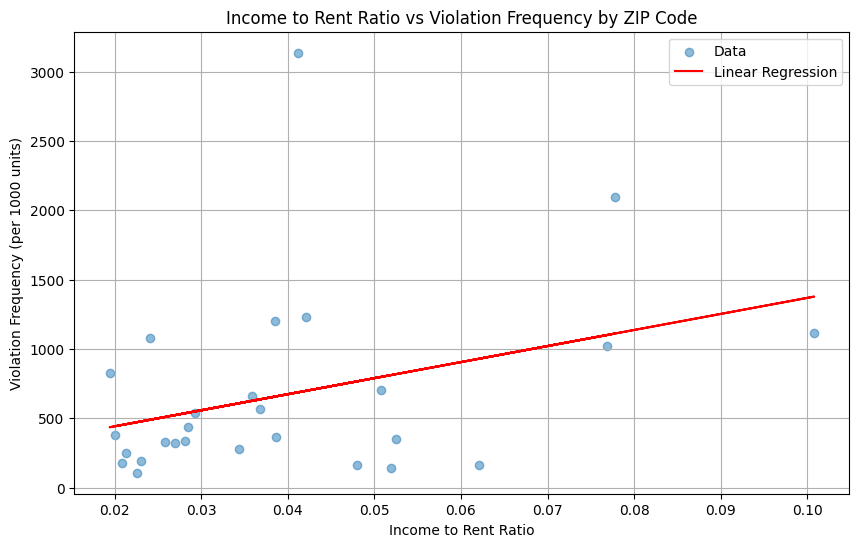

Intercept: 210.476630941976
Coefficient: 11583.5321442297
R-squared: 0.12069493363450001


In [29]:
zori_data['ZIP_CODE'] = zori_data['ZIP_CODE'].astype(int)
freq_data['ZIP_CODE'] = freq_data['ZIP_CODE'].astype(int)

# Merge datasets on ZIP code
merged_data = pd.merge(zori_data, freq_data, on='ZIP_CODE', how='inner')
merged_data = pd.merge(merged_data, zip_and_income, on='ZIP_CODE', how='inner')

merged_data['INCOME_TO_RENT_RATIO'] = merged_data['PRICE_INDEX'] / merged_data['HOUSEHOLD_INCOME']

# Prepare data for linear regression
X = merged_data['INCOME_TO_RENT_RATIO'].values.reshape(-1, 1)
y = merged_data['VIOLATION_FREQUENCY'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Predict y values
y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression')
plt.title('Income to Rent Ratio vs Violation Frequency by ZIP Code')
plt.xlabel('Income to Rent Ratio')
plt.ylabel('Violation Frequency (per 1000 units)')
plt.grid(True)
plt.legend()
plt.show()

# Print the coefficients
print('Intercept:', model.intercept_)
print('Coefficient:', model.coef_[0])
print('R-squared:', r2_score(y, y_pred))
